# Рейтинг ресторанов по версии Trip Advisor
## Задание к Юниту 3 "Проект о вкусной  и здоровой пище" 
### Анна Журавлёва, группа DST-16

В данном ноутбуке на основании предложенных датасетов выполняется предсказаниие рейтинга ресторанов по версии Trip Advisor с помощью модели Random Forest.

### Загружаем необходимые для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## Настройки представления

In [2]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

## Зафиксируем random seed для воспроизводимости экспериментов

In [3]:
RANDOM_SEED = 42

## Зафиксируем версию пакетов

In [4]:
!pip freeze > requirements.txt

## Загрузка, обзор и преобразование данных
Данные представлены в виде выложенных на kaggle двух датасетов c данными и одного датасета для представления на соревнование. Все датасеты предложены  в формате csv.

Загрузим датасеты:

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Рассмотрим первый датасет

In [6]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


В первом датасете 40000 записей и 10 колонок с информацией. Пустые значения явным образом содержатся в трёх колонках.

Рассмотрим второй датасет

In [8]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


Во втором датасете 10000 записей и 9 колонок с информацией. Пропуски в явном виде содержатся в 4 колонках. По заголовкам колонок и примерному содержанию согласно информации, видимой в head, датасеты совпадают за исключением столбца Rating, который и должен быть рассчитан по алгоритму, обученному из тестовых данных.

Рассмотрим третий датасет

In [10]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Файл представляет собой список рейтингов ресторанов в привязке к ID. Он потребуется в финальной части для предоставления данных на Kaggle.

Для корректной обработки признаков объединяем трейн и тест в один датасет.

In [12]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:

- City: Город
- Cuisine Style: Кухня
- Ranking: Ранг ресторана относительно других ресторанов в этом городе
- Price Range: Цены в ресторане в 3 категориях
- Number of Reviews: Количество отзывов
- Reviews: 2 последних отзыва и даты этих отзывов
- URL_TA: страница ресторана на 'www.tripadvisor.com'
- ID_TA: ID ресторана в TripAdvisor
- Rating: Рейтинг ресторана

Признаки требуют заполнения пропусков, преобразования и обработки.

## Очистка и преобразование данных
Рассмотрим данные в комплексе и по столбцам.
Оценим данные на наличие повторов. Функцию,высчитывающую процент пустых значений, запускать не будем, т.к. пустые значения удалению не подлежат.

In [14]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Интересно, что в категории Restaurant_id не все значения уникальны. 
Начнём рассмотрение с этой категории.

In [15]:
data['Restaurant_id'].value_counts()

id_871      19
id_436      19
id_633      19
id_227      19
id_321      18
            ..
id_11623     1
id_6715      1
id_10217     1
id_11761     1
id_14788     1
Name: Restaurant_id, Length: 13094, dtype: int64

Действительно, некоторые позиции повторяются почти 20 раз. Профильтруем датасет по топовому значению, возможно, что-то увидим.

In [16]:
data[data['Restaurant_id']=='id_436']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5


В других позициях совпадения не прослеживаются. Для дальнейшей обработки этот столбец проще всего будет просто отбросить.

### Рассмотрим города
В датасете нет явных пропусков и представлен 31 город. Посмотрим на них поближе. 

In [17]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Из перечня следует, что это действительно европейские города, как и следует из датасета. Создадим дополнительный столбец Capital, в котором присвоим категории Столица (Capital) или Город (Town).

In [18]:
cities=set(list(data['City']))
len(cities)

31

In [19]:
#Создаём словарь, где ключами являются наименования городов
cit_cap={'London': 'Capital', 'Paris': 'Capital', 'Madrid': 'Capital','Barcelona': 'Town', 'Berlin': 'Capital', 
 'Milan': 'Town', 'Rome': 'Capital','Prague': 'Capital','Lisbon': 'Capital', 'Vienna': 'Capital', 
 'Amsterdam': 'Capital', 'Brussels': 'Capital', 'Hamburg': 'Town', 'Munich': 'Town', 'Lyon': 'Town', 
 'Stockholm': 'Capital', 'Budapest': 'Capital', 'Warsaw': 'Capital', 'Dublin': 'Town', 'Copenhagen': 'Capital', 
 'Athens': 'Capital', 'Edinburgh': 'Town', 'Zurich': 'Town', 'Oporto': 'Town', 'Geneva': 'Capital',  'Krakow': 'Town',
 'Oslo': 'Capital', 'Helsinki': 'Capital', 'Bratislava': 'Capital',  'Luxembourg': 'Capital', 'Ljubljana': 'Town'}


In [20]:
len(cit_cap)

31

In [21]:
#Создаём новый столбец, значения которого являются значениями созданного словаря по ключам из колонки City
data['Capital']=data['City'].map(cit_cap)
data['Capital'].value_counts()

Capital    36770
Town       13230
Name: Capital, dtype: int64

Чтобы не плодить dummy-переменные, заменим Capital на 1, а Town на 0

In [22]:
cit_cap_0 = {'Capital':1, 'Town':0}
data['Capital']=data['Capital'].map(cit_cap_0)

В интернете удалось найти данные о количестве посещений туристами европейских городов. К сожалению, сайта, где были представлены все города из датасета, не нашлось, поэтому разные таблицы пришлось сводить в файл csv. Преобразуем их в датафрейм и объединим датафреймы по наименованию города

In [23]:
df_c = pd.read_csv('Tourism.csv')
df_c.head()

,City,1000 tourist arrivals
0,London,15.640
1,Bangkok,10.350
2,Paris,9.700
3,Singapore,9.502
4,Dubai,6.120


In [24]:
data = pd.merge(data, df_c, on='City')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Restaurant_id          50000 non-null  object 
 1   City                   50000 non-null  object 
 2   Cuisine Style          38410 non-null  object 
 3   Ranking                50000 non-null  float64
 4   Price Range            32639 non-null  object 
 5   Number of Reviews      46800 non-null  float64
 6   Reviews                49998 non-null  object 
 7   URL_TA                 50000 non-null  object 
 8   ID_TA                  50000 non-null  object 
 9   sample                 50000 non-null  int64  
 10  Rating                 50000 non-null  float64
 11  Capital                50000 non-null  int64  
 12  1000 tourist arrivals  50000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.3+ MB


## Типы кухни - 'Cuisine style'
Визуально содержимое выглядит как список. Также в наличии имеются пропуски. Прежде чем начать заниматься анализом датасета определим тип ячеек и решим, как заполнить пропуски.

In [25]:
data['Cuisine Style'][0]

"['Bar', 'Pub']"

In [26]:
type(data['Cuisine Style'][0])

str

В настоящий момент каждая ячейка представляет собой не список, а строку. Преобразуем их в "настоящий" список. Для этого предварительно заполним пропуски строкой '[]', тогда она будет преобразована в пустой список. Данные утеряны не будут.

In [27]:
data['Cuisine Style'].fillna("[]",inplace=True)
#Функция, автоматически оценивающая строку и преобразующая её в предполагаемый формат
data['Cuisine Style']=data['Cuisine Style'].apply(lambda x: ast.literal_eval(x))

Вставим дополнительный столбец Cuisines, показывающий, сколько позиций в списке категорий. Поскольку пустые значения теперь отображаются как пустой список, то их значение будет равняться 0. В дальнейшем это может пригодиться для анализа, т.к. можно будет посмотреть, какой рейтинг имеют рестораны, о которых нечего сказать.

In [28]:
data['Cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))
data['Cuisines'].value_counts()

0     11590
1      9154
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: Cuisines, dtype: int64

Теперь посмотрим, какие же категории определяют рестораны в рейтинге. Для этого циклом пройдём по каждому элементу каждого списка, запишем их в сет. Длина сета даст уникальныые значения, его содержание задаст дальнейшее направление анализа.

In [29]:
cus_set=set() #Создаём пустой сет
for c in data['Cuisine Style']:
    for i in c: #Проходим по элементам списка в каждой записи
        cus_set.add(i) #Добавляем элемент в сет, повторяющиеся значения "схлопнутся"
len(cus_set)

125

In [30]:
print(cus_set)

{'Uzbek', 'Scottish', 'Street Food', 'Egyptian', 'Central American', 'Korean', 'Caribbean', 'Dutch', 'Canadian', 'Vegetarian Friendly', 'Japanese', 'Brew Pub', 'Singaporean', 'Fujian', 'Polish', 'Israeli', 'New Zealand', 'Chilean', 'American', 'Ukrainian', 'Slovenian', 'Filipino', 'Scandinavian', 'Eastern European', 'Pub', 'Arabic', 'Asian', 'Salvadoran', 'Turkish', 'Spanish', 'Xinjiang', 'French', 'Grill', 'Norwegian', 'Healthy', 'Tibetan', 'Caucasian', 'Brazilian', 'Indian', 'Indonesian', 'Cuban', 'Balti', 'Croatian', 'Pakistani', 'Cambodian', 'Irish', 'British', 'African', 'Argentinean', 'Hungarian', 'Fusion', 'Russian', 'Steakhouse', 'Latvian', 'Soups', 'Cafe', 'Central Asian', 'Seafood', 'Ethiopian', 'Delicatessen', 'Fast Food', 'Italian', 'Romanian', 'Sri Lankan', 'Cajun & Creole', 'Jamaican', 'Middle Eastern', 'Diner', 'South American', 'Tunisian', 'Greek', 'Mediterranean', 'Wine Bar', 'Afghani', 'Burmese', 'Vietnamese', 'Welsh', 'International', 'Malaysian', 'Nepali', 'Hawaiian

Всего в сете получилось 125 уникальных позиций, указывающих как на принадлежность кухни, в том числе весьа экзотические типы, так и дополнительные опции типа бара или вегетарианских блюд. Попробуем вытащить эти признаки, создав дополнительные столбцы. Для начала создадим списки с географическими категориями, распределив их приблизительно. Логично выделить европейскую кухню (eur), арабскую (arab), паназиатскую (asian), средиземноморскую (medter), латиноамериканскую (latin). Все виды трудноопределяемых или слишком самобытных кухонь,  а также прямо указанные позиции International и Fusion можно вложить в категорию интернациональной кухни (inter). После создания списков создадим соответствующие столбцы, а также столбцы для баров и вегетарианских/веганских опциий. По умолчанию присвоим им значение 0.

In [31]:
asian = ['Yunnan',  'Vietnamese',  'Japanese',  'Tibetan',  'Bangladeshi',  'Asian',  'Thai',  'Malaysian','Xinjiang',
          'Burmese',  'Pakistani',  'Taiwanese',  'Nepali',  'Korean',  'Mongolian',  'Southwestern', 'Chinese', 
          'Indian',  'Sri Lankan',   'Central Asian',   'Filipino','Sushi',  'Singaporean','Indonesian',  
          'Minority Chinese',  'Fujian',  'Cambodian',  'Asian']
latin = ['Argentinean',  'Latin',  'South American',  'Venezuelan',  'Mexican',  'Central American',  'Ecuadorean', 
          'Cuban', 'Brazilian',  'Colombian',  'Salvadoran',  'Chilean',  'Peruvian']
inter = ['African',  'Fusion',  'Caribbean',  'Caucasian',   'International',  'New Zealand',  'Hungarian',  
          'Russian',  'Georgian',   'Polynesian',  'Cajun & Creole',   'American',  'Azerbaijani',  'Israeli', 
          'Afghani',  'Caribbean',   'Armenian',   'Jamaican',   'Hawaiian',   'Uzbek',   'Ethiopian',  'Albanian',  
          'Native American',  'Australian',   'Canadian', 'International']
eur = ['French',  'Latvian',  'Swiss', 'Polish',  'Scottish',  'Central European', 'Scandinavian',  'German', 
        'Danish', 'Belgian', 'Austrian', 'Ukrainian',  'Norwegian',  'Czech',  'Dutch', 'British',  'Croatian',  
        'Swedish',  'Slovenian',  'Irish',  'Eastern European',  'Romanian',   'Welsh', 'European']
arab = ['Arabic',  'Middle Eastern',  'Egyptian',  'Tunisian',  'Lebanese',   'Moroccan']
medter = ['Persian',  'Greek',  'Spanish',  'Portuguese',   'Italian',   'Turkish',  'Mediterranean']


In [32]:
data['Arab'] = 0
data['Asian'] = 0 
data['Europe']=0 
data['Inter']= 0 
data['Latin']=0 
data['Mediter']=0
data['Vegetarian']=0
data['Bar']=0
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Restaurant_id          50000 non-null  object 
 1   City                   50000 non-null  object 
 2   Cuisine Style          50000 non-null  object 
 3   Ranking                50000 non-null  float64
 4   Price Range            32639 non-null  object 
 5   Number of Reviews      46800 non-null  float64
 6   Reviews                49998 non-null  object 
 7   URL_TA                 50000 non-null  object 
 8   ID_TA                  50000 non-null  object 
 9   sample                 50000 non-null  int64  
 10  Rating                 50000 non-null  float64
 11  Capital                50000 non-null  int64  
 12  1000 tourist arrivals  50000 non-null  float64
 13  Cuisines               50000 non-null  int64  
 14  Arab                   50000 non-null  int64  
 15  As

Теперь циклом заполним значениями все позиции новых колоном. Логика будет следующая: при заполнении географических категорий значением позиции будет длина списка уникальных значений, совпавших как в позиции из колонки 'Cuisine Style' так и в соответствующем списке. Если совпадений не будет, длина списка будет равна нулю. Что касается колонки про бар и вегетарианские опции, то проверка будет по условию: если в списке из позиции есть одно из заданных значений, то позиции в колонке присваивается 1. 

Я намеренно не создаю для этого функцию, т.к. запуск функции для каждого заполнения заставит прокрутить цикл 8 раз.

In [33]:
v='Vegetarian Friendly' #Строковые переменные
vg='Vegan Options'
b='Bar'
wb='Wine Bar'
for i in range(50000):
    s=set(data['Cuisine Style'][i]) #Переменная, создающая сет из списка стилей кухни
    data['Arab'][i]=len(list(s&set(arab)))
    data['Asian'][i]=len(list(s&set(asian)))
    data['Europe'][i]=len(list(s&set(eur)))
    data['Inter'][i]=len(list(s&set(inter)))
    data['Mediter'][i]=len(list(s&set(medter)))
    data['Latin'][i]=len(list(s&set(latin)))
    if v in data['Cuisine Style'][i] or vg in data['Cuisine Style'][i]:
        data['Vegetarian'][i]=1
    elif b in data['Cuisine Style'][i] or wb in data['Cuisine Style'][i]:
        data['Bar'][i]=1


C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.

In [34]:
data['Inter'].value_counts()

0    45013
1     4453
2      510
3       20
4        4
Name: Inter, dtype: int64

In [35]:
data['Mediter'].value_counts()

0    35041
1     8546
2     6278
3      130
4        4
5        1
Name: Mediter, dtype: int64

In [36]:
data['Latin'].value_counts()

0    48724
1      608
2      443
3      172
4       41
5       11
8        1
Name: Latin, dtype: int64

In [37]:
data['Asian'].value_counts()

0    43578
2     2586
1     2352
3     1220
4      203
5       49
6       11
7        1
Name: Asian, dtype: int64

### Рассмотрим столбцы Ranking и Rating 
В столбца нет пропусков, значения имеют числовое представление. Преобразований а этом не требуется. Рассмотрим каждый на предмет распределения значений.

In [38]:
data.Ranking.value_counts()

93.0       22
842.0      21
491.0      21
72.0       21
1013.0     20
           ..
16021.0     1
14222.0     1
4288.0      1
13760.0     1
11264.0     1
Name: Ranking, Length: 12975, dtype: int64

In [39]:
data.Rating.value_counts()

4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

### Столбец Price range
требует преобразования. В нём есть пропуски, значения имеют тип object. Посмотрим на уникальные значения и решим, как это преобразовать.

In [40]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

В столбце всего три категории, обозначающие цену. Заменить данные можно, записав их в словарь. Обозначим значения цифрами, где 1 - дешёвые рестораны, 2 - средняя ценовая категория, 3 - дорогие. К сожалению, алгоритм, автоматически присваивающий ключу необходимое значение, получится слишком длинный. Проще задать категории вручную. 

In [41]:
dct_pr = {} #Пустой словарь для ценовых категорий
dct_pr['$']=1
dct_pr['$$ - $$$']=2
dct_pr['$$$$']=3
dct_pr

{'$': 1, '$$ - $$$': 2, '$$$$': 3}

Заменим значения по словарю и посмотрим, что получилось.

In [42]:
data['Price Range']=data['Price Range'].map(dct_pr)
data['Price Range'].value_counts()

2.0    23041
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

В категории очень много пропущенных значений. Их можно заполнить нулями, но для целей достоверности попробуем заполнить средней ценовой категорией для ресторанов в ***соответствующем городе***. 

In [43]:
data['Price Range'].fillna(0, inplace=True) #Записываем в пропуски нули для условия
for i in range(50000):
    if data['Price Range'][i]==0:
        x=round(data[data['City']==data['City'][i]]['Price Range'].mean()) #Среднее округлённое значение
        data['Price Range'][i]=x
data['Price Range'].value_counts()

C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2.0    25565
1.0    22653
3.0     1782
Name: Price Range, dtype: int64

### Столбцы Number of Reviews и Reviews
стоит рассмотреть совместно, т.к. они связаны даже судя по названиям. При этом в столбце Количество отзывов есть пропуски, а вот в самих отзывах таких пропусков почти нет. 2 случая на 50000 не считаются. Посмотрим, что там происходит.

In [44]:
data['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
1082.0       1
1741.0       1
2175.0       1
2174.0       1
1543.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

In [45]:
data['Reviews'].value_counts()

[[], []]                                                                                                                          8112
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                    2
[['Healthy vegan doughnuts are posible', 'Best Vegan Donut in the world !!!'], ['11/17/2017', '11/16/2017']]                         2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                                             2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                                              2
                                                                                                                                  ... 
[['A goo selection of lagers and keg beers, w...', 'Now called The Beer House. Disappointing.'], ['08/23/2017', '01/15/2017']]       1
[['Order at your own risk ...', 'Terrible delivery expe

In [46]:
type(data['Reviews'][0])

str

В отзывах мы видим ту же ловушку, что и в стилях кухни: визуально это выглядит как список из списков, но по факту это строка. Также недоумение по поводу отсутствия пропусков в данной колонке неслучайно. На самом деле вместо настоящего пропуска - пустые скобки. 

Также интересно и то, что некоторые позиции дублируются. Посмотрим, что это значит для первого такого дубля.

In [47]:
data[data['Reviews']=="[['Good service and clean', 'Chinese fusion cuisine - ok to try if you...'], ['11/21/2017', '05/23/2017']]"]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Capital,1000 tourist arrivals,Cuisines,Arab,Asian,Europe,Inter,Latin,Mediter,Vegetarian,Bar
35451,id_6140,Madrid,"[Chinese, Asian, Vegetarian Friendly, Vegan Op...",3053.0,2.0,148.0,"[['Good service and clean', 'Chinese fusion cu...",/Restaurant_Review-g187514-d4748208-Reviews-Re...,d4748208,0,0.0,1,3.921,4,0,2,0,0,0,0,1,0
38061,id_2988,Madrid,"[Chinese, Asian, Vegetarian Friendly, Vegan Op...",2990.0,2.0,148.0,"[['Good service and clean', 'Chinese fusion cu...",/Restaurant_Review-g187514-d4748208-Reviews-Re...,d4748208,1,3.5,1,3.921,4,0,2,0,0,0,0,1,0


Получается, что это один и тот же ресторан, но в разных датасетах: тренировочном и итоговом. Интересно, что совпадает всё, кроме ранкинга. 
Начнём обработку данных. Для начала заполним пропуски в столбце Reviews строковым выраежением [[], []], которое в данном случае означает невыгруженные отзывы или их полное отсутствие.

In [48]:
data['Reviews'].fillna('[[], []]', inplace=True)

Теперь заполним пропуски в столбце Number of Reviews. Если при этом в столбце с отзывами действительно пустые скобки, то будем считать, что отзывов нет. Если другое значение, то как минимум 1 должен быть.

In [49]:
data[data['Reviews']== '[[], []]']['Number of Reviews'].fillna(0, inplace=True)
data['Number of Reviews'].fillna(1, inplace=True)

C:\Users\Anna\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Добавим столбец с количеством отзывов в городе.

In [50]:
data['Number of Reviews city']=0
for i in range(len(data['Reviews'])):
    data['Number of Reviews city'][i]=data[data['City']==data['City'][i]]['Number of Reviews'].sum()

C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Проведём преобразованиие столбца в список по такой же методике, как и со стилями кухни. Но теперь у нас должен получиться список из двух списков: в первом первые строки отзыва, во втором - даты этих отзывов. Поскольку при первичном запуске выходила ошибка, поиск её причин выявил несколько строк в которых текст отзыва не подтянулся, а было записано nan, в строковом формате. Для начала заменим это выражением 'no review'.

In [51]:
for i in range(50000):
    if data['Reviews'][i].find('nan]')>0 or data['Reviews'][i].find('nan,')>0:
        data['Reviews'][i]=data['Reviews'][i].replace('nan',"'no review'")
        print(data['Reviews'][i])

C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[['Will certainly be back', 'no review'], ['11/26/2017', '07/27/2017']]
[['no review', 'Good food with decent service'], ['11/21/2017', '07/21/2017']]


In [52]:
for i in range(50000):
    data['Reviews'][i]=ast.literal_eval(data['Reviews'][i])


C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Получившиеся списки списков разделим на два столбца. В столбце Review_text будет список из двух отзывов, в столбце Review_Date - список дат в текстовом формате.

In [53]:
data['Review_text']=data['Reviews'].apply(lambda x: x[0])

Посмотрим тип получившейся позиции в новом столбце

In [54]:
type(data['Review_text'][1])

list

In [55]:
type(data['Review_text'][1][0])

str

У нас получился список из строк, которые на самом деле представляют собой предложение/заголовок отзыва, текст которого , видимо, представлен на сайте. Попробуем посчитать количество слов в каждом таком заголовке, а также по аналогии с видами кухонь попытаетмся посмотреть на список слов.

In [56]:
# Вставим столбец Review_words со значением по умолчанию 0.
data['Review_words']=0

Почистим записи от лишних символов и знаков препинания, посчитаем количество слов и создадим перечень встречающихся слов. 

In [57]:
i = -1 #Счётчик
words = [] #Пока пустое множество слов
for reviews in data['Review_text']:
    i += 1
    a = 0 # Обнуляем количество слов в первом и втором элементе списка
    b = 0
    if len(reviews)==2:
        # Удаляем все небуквенные символы
        word1 = re.sub(r'\W', ' ', reviews[0])
        word2 = re.sub(r'\W', ' ', reviews[1])
        # Удаляем все одиночные буквы (могли остаться от удаления апострофа)
        word1 = re.sub(r'\s+[a-zA-Z]\s+', ' ', word1)
        word2 = re.sub(r'\s+[a-zA-Z]\s+', ' ', word2)
        # Удаляем одиночные символы с начала
        word1 = re.sub(r'\^[a-zA-Z]\s+', ' ', word1)
        word2 = re.sub(r'\^[a-zA-Z]\s+', ' ', word2)
        # Заменяем множественные пробелы одним
        word1 = re.sub(r'\s+', ' ', word1, flags=re.I)
        word2 = re.sub(r'\s+', ' ', word2, flags=re.I)
        # Удаляем префикс 'b'
        word1 = re.sub(r'^b\s+', '', word1)
        word2 = re.sub(r'^b\s+', '', word2)
        # Переводим все слова в строчной регистр
        word1 = word1.lower()
        word2 = word2.lower()
        # Считаем количество слов по принципу количество пробелов +1
        a = word1.count(' ') + 1
        b = word2.count(' ') + 1
        data['Review_words'][i] = a + b 
        word = word1 + ' ' + word2
        word_list = list(map(str, word.split()))
        words.extend(word_list)
    elif len(reviews)==1:
        word1 = re.sub(r'\W', ' ', reviews[0])
        word1 = re.sub(r'\s+[a-zA-Z]\s+', ' ', word1)
        word1 = re.sub(r'\^[a-zA-Z]\s+', ' ', word1)
        word1 = re.sub(r'\s+', ' ', word1, flags=re.I)
        word1 = re.sub(r'^b\s+', '', word1)
        word1 = word1.lower()
        a = word1.count(' ') + 1
        data['Review_words'][i] = a
        word_list = list(map(str, word1.split()))
        words.extend(word_list)


C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
len(words)


305806

In [59]:
data['Review_words'].value_counts()

0     8114
7     5196
8     4780
6     4773
9     4381
5     4181
10    3576
4     3180
11    2774
12    2146
3     1868
13    1518
2     1113
14     935
15     548
16     329
1      301
17     173
18      77
19      28
20       8
21       1
Name: Review_words, dtype: int64

In [60]:
words.sort()
words = set(words)
print(len(words), words)

14948 {'kebabs', 'express', 'rudely', 'cozy', 'le', 'stars', 'bayerisch', 'freezing', 'foodcourt', 'dei', 'paneria', 'medium', 'popular', 'fragrant', 'schanzenviertel', 'heathy', 'siam', 'watch', 'khoshmazeh', 'sirenas', 'crave', 'picturesque', 'cuban', 'inexpensive', 'europ', 'directly', 'solution', 'mmmust', 'divebar', 'bette', 'improvised', 'ropey', 'neiborhood', 'avera', 'yearly', 'martinigansl', 'excel', 'underperforming', 'notre', 'snac', 'lines', 'sarchbar', 'japanese', 'niice', 'seafront', 'brave', 'gyros', 'feltman', 'saumon', 'worked', 'portugalia', 'bedford', 'accomadating', 'medal', 'herzlich', 'woolwich', '000', 'feel', 'frustrating', 'rapide', 'pretend', 'sham', 'hazard', 'decieved', 'wasabi', 'tentazioni', 'grump', 'homolje', '9th', 'sandra', 'serivceminded', 'disagree', 'tooo', 'nearest', 'brinch', 'whenever', 'newyear', 'seafood', 'muslims', 'sail', 'sightsee', 'laietana', 'reminder', 'helsinki', 'forman', 'bust', 'krakau', 'lacks', 'méat', 'tongue', 'ramey', 'inconsis

Создадим словари негативных и позитивных слов (выберем только самые яркие)

In [61]:
#Список негативных слов
minus = ['absurdly', 'abundance', 'abundant', 'abusive', 'aggresive', 'aggressive', 'agressive', 'angry', 'annoyed', 'annoying', 'annoyingly', 'anxiety', 'argumentive', 'arrogance', 'arrogant', 'ashame', 'ashamed','awefull', 'awful','awfull','awfully', 'bad','badly','betrug', 'boring', 'cancel','canceled','cancellation', 'cancelled','catastrophe', 'catastrophic', 'catastrophy','chaos', 'chaot', 'chaotic','chaotically','closed', 'closes','collapse','conflicting', 'conflictual','confused','confusing', 'confusio','confusion','danger', 'dangerous','dangerously','delay', 'delayed','depressing','desappointing', 'dirtiest','dirty','disapointing', 'disapointment','disapoointing','disappear', 'disappearing','disappo','disappoi', 'disappoin','disappoing','disappoinment', 'disappoint','disappointe','disappointed', 'disappointin','disappointing', 'disappointingly','disappointme','disappointmen','disappointment','disappointments','disappoints','disapponiting','disapponted','disaster','disasterous','disastrous','disguise','disgusted','disgusti','disgusting','disgustingly','dispointed','disppointing','dissapoint','dissapointed','dissapointing','dissapointment','dissapoints','expencieve','expencive','expenive','expensiv','expensive','exspencive','flavorless','horribly','hysterically','impolite','inadequate','inappropriate','inattentive','inauthentic','incompetent','incomplete','incomprehensible','inconsiderate','inconsistent','inconspicuous','incontournable','inconvenient','inedible','irritated','miserable','mistake','mistakes','overcharge','overcharged','overcharging','overcrowded','overestimated','poisening','poison','poisoned','poisoning','poisson','rubbish','rubish','rud','rude','rudely','rudeness','sexist','sick','spoil','spoiled','spoils','spoilt','stole','stolen','tasteless','tastless','theft','thief','thiefs','thieves','trash','trashy','ugliest','ugly','unacceptable','unacceptably','unaccomodating','unappealing','unappetising','unattractive','unclean','uncomfortable','unconvincing','unfirendly','unforgiving','unfortunate','unfortunately','unfortunetly','unfriendliest','unfriendly','unhappy','unhealthy','unhelpful','unhygenic','unhygienic','unimpressible','unimpressive','unintentionally','unintereste','uninterested','uninteresting','unlucky','unorganized','unpleasant','unpleasent','unpolite','unprofessi','unprofessional','unprofessionnal','unreasonable','unreasonably','unreliable','unsanitary','unsatisfactory','unsatisfied','unsatisfying','unstable','untasetiness','untasty','untrained','untrendy','unwanted','unwelcome','unwelcoming','urin','urinals','vandalism','waste','wasted','wasting']
# Список позитивных слов
plus = ['delicieux','délicieux','delicious','deliciouse','deliciously','deliciuos','delicius','delicous','delighful','delight','delighted','delightful','delightfully','delighthful','delights','excelent','excelente','excell','excellant','excelle','excellect','excellen','excellence','excellenct','excellency','excellent','excellente','excellento','excellet','excellient','excit','excite','excited','excitement','exciting','excitingly','excllent','execellent','execerlent','execllent','exelent','exellence','exellent','extroardinary','exzellent','faboulous','fabukous','fabul','fabulius','fabulo','fabulos','fabulous','fabulously','fabuloussss','favorites','favour','favourite','favourites','favours','favurite','flavorful','flavorfull','friendl','friendlier','friendliest','friendliness','friendlly','friendly','friéndly','friends','friendy','good','goodfood','goood','gooood','goooood','gooooood','horrific','hospitality','hospitallity','hospitalty','impressing','impressions','impressive','impressively','accceptable',' advantage',' alright',' alright',' amazed',' amazi',' amazin',' amazinf',' amazing','amazinggggg','amazingly','amazingness','amazlingly','amazng','amazzzzzing','ammmmazzzzingggg','attractive','autenthic','autentic','autenticity','auwsome','awesom','awesome','awesomer','awesone','awessome','awseome','awsom','awsome','beatiful','beaultiful','beaut','beautful','beauti','beautifu','beautiful','beautifull','beautifully','beauty','beaux','bellisima','bellisimo','bellisomo','bellissimo','bello','best','bestt','besttt','blessed','blessing','bonito','bonne','bonnes','breathtaking','briliant','brill','brillante','brilliance','brilliant','brilliantly','buon','buona','buonísimo','buonissimo','buono','charm','charmed','charmig','charmin','charming','charmy','classic','classical','classically','classy','comfort','comforta','comfortable','comfortably','compliment','compliments','congrat','congratulations','convenient','conveniently','delcious','delecious','delicetessen','délicieuse','incredible','incredibly','incredicle','inviting','irresistible','loveley','lovelier','loveliest','lovely','ĺovely','luxe','luxurious','luxuruious','mmmhhhhh','mmmm','mmmmm','mmmmmm','mmmmmmhh','mmmmmmmm','mmmmmmmmmmmmmmm','outsanding','outstandin','outstanding','outstandingly','outstanging','perfect','perfecto','perfecton','phantastic','perfect','perfecto','perfecton','phantastic','phenomenal','pleasant','pleasantl','pleasantly','pleasat','pleased','pleasent','pleasently','pleaser','pleaseure','pleasing','pleasur','pleasurable','pleasurably','pleasure','pleasures','plesant','pleseant','reccomendation','recomend','recomended','recommendable','sensation','sensational','sensationnel','spectacular','spectacularly','splendid','splendiferous','splendour','super','sympatic','tasteful','tastefull','tastefully','tasty','tastyy','tastyyy','tastyyyyy','thank','thankf','thankful','thankfully','thanks','tidy','unbeatable','underestimated','underrated','unforgetable','unforgettable','unglaublich','unmemorable','wondeful','wondefully','wonder','wonderdful','wonderfu','wonderful','wonderfull','wonderland','wondersful','wonderul','wonderwull','wondrful','wow','wowsers','woww','wowwwwww','wunderbar','wunderfull','wunderschön','yam','yami','yammi','yammy','yeah','yeap','yes','yess','yum','yumm','yummi','yummie','yummiest','yummii','yumminess','yummm','yummmm','yummmmm','yummmmmm','yummmmmmmmmmmmmmmmmmmmmmmmmmmmm','yummmmmy','yummy','yummyy','yummyyyyy','yums','yumy','yuuuum']


Создадим столбец reviews_eval с приблизительным тоном отзыва. 0- негативный, 1- нейтральный, 2 - позитивный. По умолчанию присвоим значение 1.

In [62]:
data['Reviews_eval'] = 1

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  object 
 1   City                    50000 non-null  object 
 2   Cuisine Style           50000 non-null  object 
 3   Ranking                 50000 non-null  float64
 4   Price Range             50000 non-null  float64
 5   Number of Reviews       50000 non-null  float64
 6   Reviews                 50000 non-null  object 
 7   URL_TA                  50000 non-null  object 
 8   ID_TA                   50000 non-null  object 
 9   sample                  50000 non-null  int64  
 10  Rating                  50000 non-null  float64
 11  Capital                 50000 non-null  int64  
 12  1000 tourist arrivals   50000 non-null  float64
 13  Cuisines                50000 non-null  int64  
 14  Arab                    50000 non-null

In [64]:
for i in range(len(data['City'])):
    if len(data['Review_text'][i])==1:
        for m in minus:
            if m in data['Review_text'][i][0]:
                data['Reviews_eval'][i] = 0
        for p in plus:
            if p in data['Review_text'][i][0]:
                data['Reviews_eval'][i] = 2
    elif len(data['Review_text'][i])==2:
        a = 1
        b = 1
        for m in minus:
            if m in data['Review_text'][i][0]:
                a = 0
            if m in data['Review_text'][i][1]:
                b = 0
        for p in plus:
            if p in data['Review_text'][i][0]:
                a = 2
            if p in data['Review_text'][i][1]:
                b = 2
        data['Reviews_eval'][i] = round((a+b)/2)

C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [65]:
data['Reviews_eval'].value_counts()

1    36914
2    11645
0     1441
Name: Reviews_eval, dtype: int64

Обработаем информацию по датам. Создадим столбец со списком дат. Теперь это просто элемент получившегося списка с индексом [1]. В каждой позиции будет от 0 до 2 элементов. Затем посмотрим, когда был написан последний отзыв. По умолчанию поставим значение 5500, оно останется для позиций, по которым отзывов не было.

In [66]:
data['Review_Date']=data['Reviews'].apply(lambda x: x[1])
data['Latest Review']=5500

In [67]:
date = datetime.now() #Сегодняшняя дата
i=-1
for ddd in data['Review_Date']: #Список дат в строковом виде 
    i+=1
    for dd in ddd: #Элемент списка
        if len(ddd)==1:
            d=datetime.strptime(dd, '%m/%d/%Y')
            z = date-d      #Разница с единственной датой
            data['Latest Review'][i]=int(z.days) 
        elif len(ddd)==2:
            x=datetime.strptime(ddd[0], '%m/%d/%Y')
            y=datetime.strptime(ddd[1], '%m/%d/%Y')
            z=date-max(x,y) #Разница с позднейшей из двух дат
            data['Latest Review'][i]=int(z.days)
data['Latest Review'].value_counts()

C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anna\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


5500    8114
987      646
991      568
988      522
990      492
        ... 
2599       1
3568       1
3152       1
2887       1
2049       1
Name: Latest Review, Length: 1977, dtype: int64

Отметим, что значения 5500 по количеству совпадают с известными нам пустыми значениями списка. Алгоритм сработал.

### Рассмотрим столбцы URL_TA и ID_TA

In [68]:
data['URL_TA'].head(10)

0    /Restaurant_Review-g187147-d10746918-Reviews-L...
1    /Restaurant_Review-g187147-d8458643-Reviews-Le...
2    /Restaurant_Review-g187147-d7605609-Reviews-Le...
3    /Restaurant_Review-g187147-d11953078-Reviews-B...
4    /Restaurant_Review-g187147-d9597870-Reviews-La...
5    /Restaurant_Review-g187147-d3256188-Reviews-Th...
6    /Restaurant_Review-g187147-d1326624-Reviews-Le...
7    /Restaurant_Review-g187147-d695231-Reviews-Buf...
8    /Restaurant_Review-g187147-d1439340-Reviews-To...
9    /Restaurant_Review-g187147-d4988279-Reviews-Le...
Name: URL_TA, dtype: object

In [69]:
data['ID_TA'].head(10)

0    d10746918
1     d8458643
2     d7605609
3    d11953078
4     d9597870
5     d3256188
6     d1326624
7      d695231
8     d1439340
9     d4988279
Name: ID_TA, dtype: object

ID_TA представляет собой часть записи URL_TA. URL_TA была бы полезна при условии живых ссылок, если бы можно было сделать приличный анализ по облаку слов. Но квалификации на это объективно не хватает. Поэтому сразу удалим эти столбцы. Также удалим Cuisine Style, так как нужную информацию мы уже получили.

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  object 
 1   City                    50000 non-null  object 
 2   Cuisine Style           50000 non-null  object 
 3   Ranking                 50000 non-null  float64
 4   Price Range             50000 non-null  float64
 5   Number of Reviews       50000 non-null  float64
 6   Reviews                 50000 non-null  object 
 7   URL_TA                  50000 non-null  object 
 8   ID_TA                   50000 non-null  object 
 9   sample                  50000 non-null  int64  
 10  Rating                  50000 non-null  float64
 11  Capital                 50000 non-null  int64  
 12  1000 tourist arrivals   50000 non-null  float64
 13  Cuisines                50000 non-null  int64  
 14  Arab                    50000 non-null

In [71]:
data.drop(data.columns[[2,6,7,8,23,26]], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  object 
 1   City                    50000 non-null  object 
 2   Ranking                 50000 non-null  float64
 3   Price Range             50000 non-null  float64
 4   Number of Reviews       50000 non-null  float64
 5   sample                  50000 non-null  int64  
 6   Rating                  50000 non-null  float64
 7   Capital                 50000 non-null  int64  
 8   1000 tourist arrivals   50000 non-null  float64
 9   Cuisines                50000 non-null  int64  
 10  Arab                    50000 non-null  int64  
 11  Asian                   50000 non-null  int64  
 12  Europe                  50000 non-null  int64  
 13  Inter                   50000 non-null  int64  
 14  Latin                   50000 non-null

## EDA
Посмотрим распределение признаков, взаимосвязь, определим выбросы.

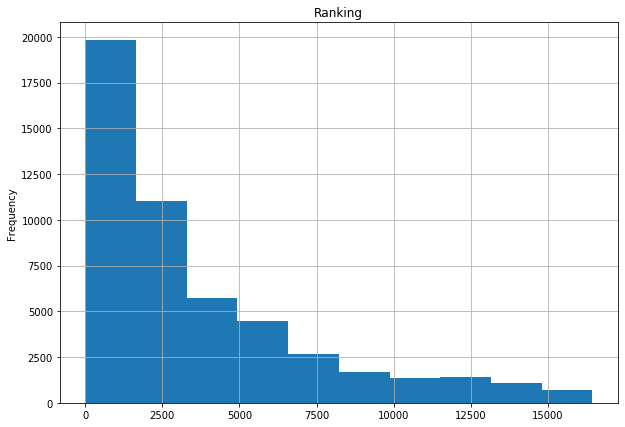

In [72]:
#Распределение значений по Ranking
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].plot(kind = 'hist', grid = True, title = 'Ranking')

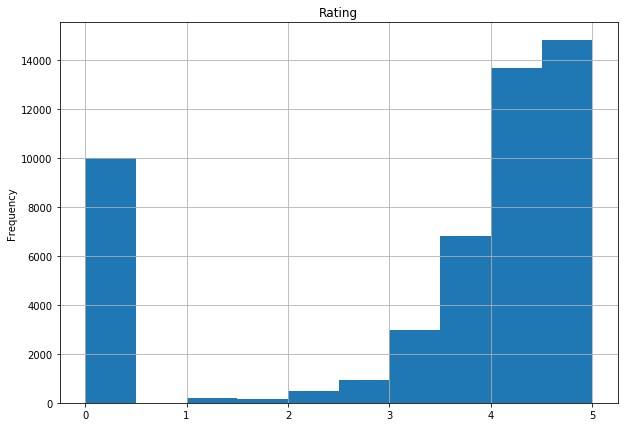

In [73]:
#Распределение значений по Rating
plt.rcParams['figure.figsize'] = (10,7)
data['Rating'].plot(kind='hist', grid=True, title='Rating')

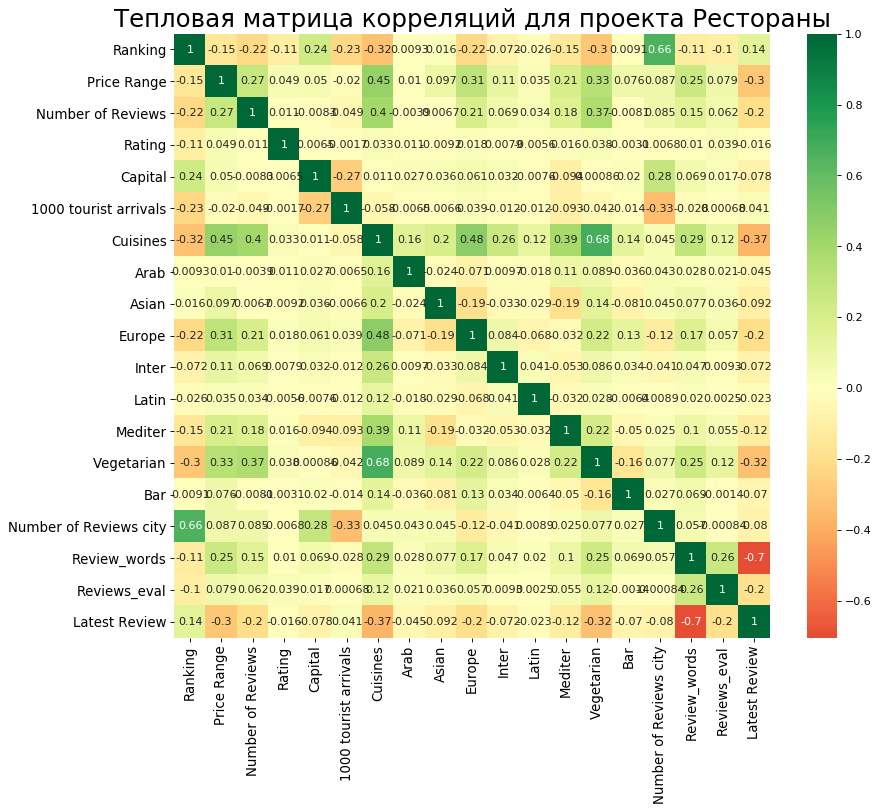

In [74]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.drop(['sample'], axis=1).corr(), xticklabels=data.drop(['sample'], axis=1).corr().columns, yticklabels=data.drop(['sample'], axis=1).corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Тепловая матрица корреляций для проекта Рестораны', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Серьёзных корреляций не выявлено. Кандидатов на удаление по итогам этой таблицы нет.

Посмотрим на распределение категориальных признаков в боксплоте.

In [75]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Rating', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

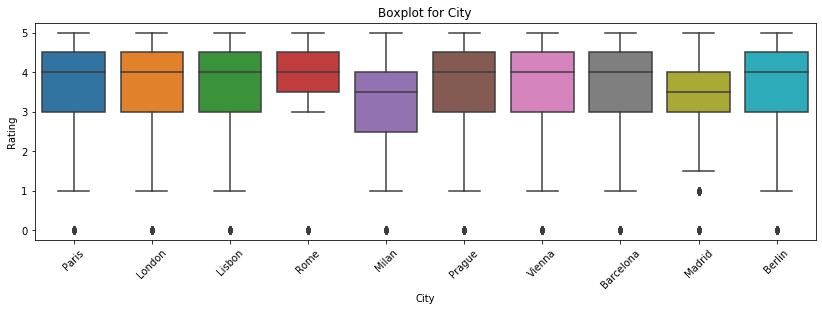

In [76]:
get_boxplot('City')

Почему-то в рейтингах хуже других выглядят Милан и Мадрид, возможно, там более привередливая публика. А вот разницы между столичными и не столичными городами не видно совсем.

Заменим оставшиеся категориальные столбцы на dummy-переменные и снова запустим корреляции.

In [77]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [78]:
data=data.drop(['Restaurant_id', 'City_nan'], axis = 1)

Теперь подготовим данные для запуска модели. Снова разделим датасет на тренировочную и тестовую части.

In [79]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [80]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

Создаём модель

In [83]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [84]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [86]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.204325625


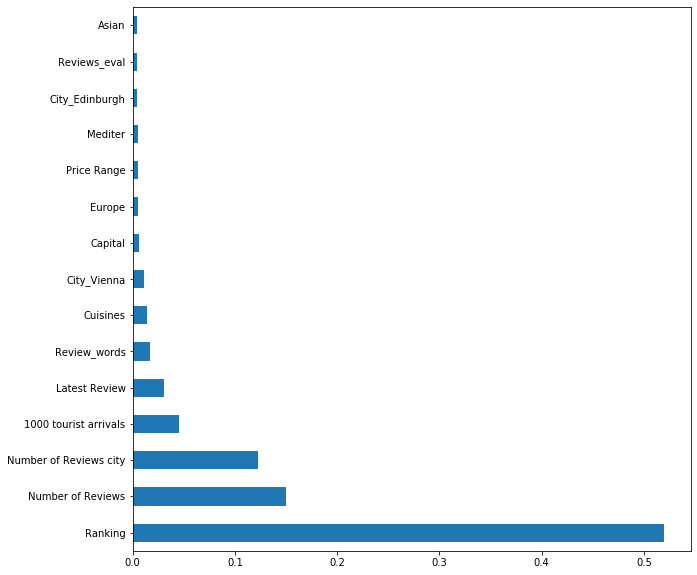

In [87]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Готовим Submission

In [88]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Capital,1000 tourist arrivals,Cuisines,Arab,Asian,Europe,Inter,Latin,Mediter,Vegetarian,Bar,Number of Reviews city,Review_words,Reviews_eval,Latest Review,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
7362,8204.0,1.0,3.0,0.0,1,15.640,0,0,0,0,0,0,0,0,0,934195,9,2,999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43473,2032.0,2.0,192.0,0.0,0,715.000,6,0,0,2,0,0,0,0,1,93999,6,1,1187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
35404,86.0,2.0,429.0,0.0,1,3.921,6,0,0,1,0,0,2,1,0,357423,10,2,988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
48550,35.0,2.0,275.0,0.0,0,1.369,8,0,0,2,0,0,2,1,0,46809,14,2,1105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35561,831.0,3.0,134.0,0.0,1,3.921,4,0,3,0,0,0,0,1,0,357423,10,2,1197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8282,7432.0,2.0,340.0,0.0,1,15.640,3,0,0,1,0,0,0,0,1,934195,12,1,1010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
571,5398.0,1.0,18.0,0.0,1,9.700,1,0,0,1,0,0,0,0,0,681118,6,2,1909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
30594,877.0,2.0,86.0,0.0,0,4.695,3,0,0,0,0,0,2,0,0,429667,6,1,1182,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18964,874.0,2.0,213.0,0.0,1,6.033,5,0,0,0,0,0,2,1,0,728311,5,1,1021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15100,1188.0,1.0,23.0,0.0,1,1.715,2,0,0,0,0,2,0,0,0,196458,3,1,1281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
test_data = test_data.drop(['Rating'], axis=1)

In [90]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [91]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [92]:
predict_submission

array([3.045, 4.405, 3.15 , ..., 4.08 , 4.36 , 4.395])

In [93]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.045
1,id_1,4.405
2,id_2,3.150
3,id_3,4.915
4,id_4,4.565
5,id_5,3.740
6,id_6,3.775
7,id_7,2.865
8,id_8,3.275
9,id_9,3.910
